# 10. Milestone Project 3: Time series forecasting in TensorFlow (BitPredict 💰📈)

The goal of this notebook is to get you familiar with working with time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin. 

Welcome to Milestone Project 3, BitPredict 💰📈!

> 🔑 **Note:** ⚠️ This is not financial advice, as you'll see time series forecasting for stock market prices is actually quite terrible.

## What is a time series problem?

Time series problems deal with data over time.

Such as, the number of staff members in a company over 10-years, sales of computers for the past 5-years, electricity usage for the past 50-years.

The timeline can be short (seconds/minutes) or long (years/decades). And the problems you might investigate using can usually be broken down into two categories.

![example time series problems](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-example-time-series-problems.png)

| Problem Type | Examples | Output |
| ----- | ----- | ----- |
| **Classification** | Anomaly detection, time series identification (where did this time series come from?) | Discrete (a label) |
| **Forecasting** | Predicting stock market prices, forecasting future demand for a product, stocking inventory requirements | Continuous (a number) |

In both cases above, a supervised learning approach is often used. Meaning, you'd have some example data and a label assosciated with that data.

For example, in forecasting the price of Bitcoin, your data could be the historical price of Bitcoin for the past month and the label could be today's price (the label can't be tomorrow's price because that's what we'd want to predict).

Can you guess what kind of problem BitPredict 💰📈 is?

## What we're going to cover

Are you ready?

We've got a lot to go through. 

* Get time series data (the historical price of Bitcoin)
  * Load in time series data using pandas/Python's CSV module
* Format data for a time series problem
  * Creating training and test sets (the wrong way)
  * Creating training and test sets (the right way)
  * Visualizing time series data
  * Turning time series data into a supervised learning problem (windowing)
  * Preparing univariate and multivariate (more than one variable) data
* Evaluating a time series forecasting model
* Setting up a series of deep learning modelling experiments
  * Dense (fully-connected) networks
  * Sequence models (LSTM and 1D CNN)
  * Ensembling (combining multiple models together)
  * Multivariate models
  * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
* Creating a modelling checkpoint to save the best performing model during training
* Making predictions (forecasts) with a time series model
* Creating prediction intervals for time series model forecasts
* Discussing two different types of uncertainty in machine learning (data uncertainty and model uncertainty)
* Demonstrating why forecasting in an open system is BS (the turkey problem) 

## How you can use this notebook
You can read through the descriptions and the code (it should all run), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

> 📖 **Resource:** Get all of the materials you need for this notebook on the [course GitHub](https://github.com/mrdbourke/tensorflow-deep-learning).

## Get data

To build a time series forecasting model, the first thing we're going to need is data.

And since we're trying to predict the price of Bitcoin, we'll need Bitcoin data.

Specifically, we're going to get the prices of Bitcoin from 01 October 2013 to 18 May 2021.

Why these dates?

Because 01 October 2013 is when our data source ([Coindesk](https://www.coindesk.com/price/bitcoin)) started recording the price of Bitcoin and 18 May 2021 is when this notebook was created.

If you're going through this notebook at a later date, you'll be able to use what you learn to predict on later dates of Bitcoin, you'll just have to adjust the data source.

> 📖 **Resource:** To get the Bitcoin historical data, I went to the [Coindesk page for Bitcoin prices](https://www.coindesk.com/price/bitcoin), clicked on "all" and then clicked on "Export data" and selected "CSV". 

You can find the data we're going to use on [GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv).




In [4]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

In [1]:
import pandas as pd
import numpy as np

In [2]:
# parse dates and set date column to index
df = pd.read_csv('bitcoin.csv',
                parse_dates=['Date'],
                index_col=['Date']) # parse the date column (tell pandas column 1 is datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's only 2787 total samples.

This is something you'll run into with time series data problems. Often, the number of samples isn't as large as other kinds of data.

For example, collecting one sample at different time frames results in:

| 1 sample per timeframe | Number of samples per year |
| ----- | ----- |
| Second | 31,536,000 |
| Hour | 8,760 |
| Day | 365 |
| Week | 52 |
| Month | 12 |

> 🔑 **Note:** The frequency at which a time series value is collected is often referred to as **seasonality**. This is usually mesaured in number of samples per year. For example, collecting the price of Bitcoin once per day would result in a time series with a seasonality of 365. Time series data collected with different seasonality values often exhibit seasonal patterns (e.g. electricity demand behing higher in Summer months for air conditioning than Winter months). For more on different time series patterns, see [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html).

![different types of time series patterns](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-types-of-time-series-patterns.png)
*Example of different kinds of patterns you'll see in time series data. Notice the bottom right time series (Google stock price changes) has little to no patterns, making it difficult to predict. See [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html) for full graphic.*

Deep learning algorithms usually flourish with lots of data, in the range of thousands to millions of samples.

In our case, we've got the daily prices of Bitcoin, a max of 365 samples per year.

But that doesn't we can't try them with our data.

To simplify, let's remove some of the columns from our data so we're only left with a date index and the closing price.

In [9]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)':'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Much better!

But that's only five days worth of Bitcoin prices, let's plot everything we've got.

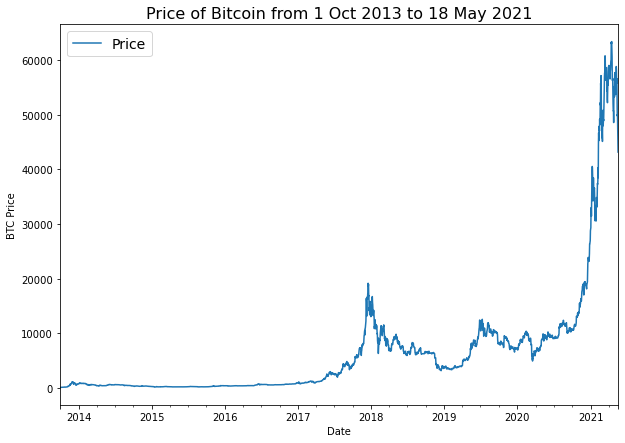

In [10]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021',fontsize=16)
plt.legend(fontsize=14)

### Importing time series data with Python's CSV module

If your time series data comes in CSV form you don't necessarily have to use pandas.

You can use Python's [in-built `csv` module](https://docs.python.org/3/library/csv.html). And if you're working with dates, you might also want to use Python's [`datetime`](https://docs.python.org/3/library/datetime.html).

Let's see how we can replicate the plot we created before except this time using Python's `csv` and `datetime` modules.

> 📖 **Resource:** For a great guide on using Python's `csv` module, check out Real Python's tutorial on [Reading and Writing CSV files in Python](https://realpython.com/python-csv/).

In [13]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open('bitcoin.csv','r') as f:
    csv_reader = csv.reader(f,delimiter=',') # read in the target csv
    next(csv_reader) # skip first line (this gets rid of the column titles)
    for line in csv_reader:
        # get the dates as dates (not strings), strptime = string parse time
        timesteps.append(datetime.strptime(line[1],'%Y-%m-%d'))
        # get the closing price as float
        btc_price.append(float(line[2]))

# view first 10 of each
for t,p in zip(timesteps[:10],btc_price[:10]):
    print(t,p)

2013-10-01 00:00:00 123.65499
2013-10-02 00:00:00 125.455
2013-10-03 00:00:00 108.58483
2013-10-04 00:00:00 118.67466
2013-10-05 00:00:00 121.33866
2013-10-06 00:00:00 120.65533
2013-10-07 00:00:00 121.795
2013-10-08 00:00:00 123.033
2013-10-09 00:00:00 124.049
2013-10-10 00:00:00 125.96116


Text(0, 0.5, 'BTC Price')

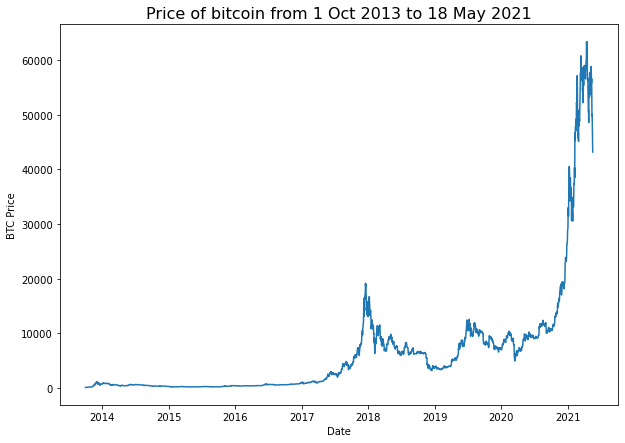

In [15]:
plt.figure(figsize=(10,7))
plt.plot(timesteps,btc_price)
plt.title('Price of bitcoin from 1 Oct 2013 to 18 May 2021',fontsize=16)
plt.xlabel('Date')
plt.ylabel('BTC Price')

## Format Data Part 1: Creatining train and test sets for time series data

Alrighty. What's next?

If you guessed preparing our data for a model, you'd be right.

What's the most important first step for preparing any machine learning dataset?

Scaling?

No...

Removing outliers?

No...

How about creating train and test splits?

Yes! 

Usually, you could create a train and test split using a function like Scikit-Learn's outstanding [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) but as we'll see in a moment, this doesn't really cut it for time series data.

But before we do create splits, it's worth talking about what *kind* of data we have.

In time series problems, you'll either have **univariate** or **multivariate** data.

Can you guess what our data is?

* **Univariate** time series data deals with *one* variable, for example, using the price of Bitcoin to predict the price of Bitcoin.
* **Multivariate** time series data deals with *more than one* variable, for example, predicting electricity demand using the day of week, time of year and number of houses in a region.

![comparison of univariate and multivariate time series data](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-univariate-and-multivariate-time-series-data.png)
*Example of univariate and multivariate time series data. Univariate involves using the target to predict the target. Multivariate inolves using the target as well as another time series to predict the target.*

### Create train & test sets for time series (the wrong way)

Okay, we've figured out we're dealing with a univariate time series, so we only have to make a split on one variable (for multivariate time series, you will have to split multiple variables). 

How about we first see the *wrong way* for splitting time series data?

Let's turn our DataFrame index and column into NumPy arrays.

In [16]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()
timesteps[:10],prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

And now we'll use the ever faithful `train_test_split` from Scikit-Learn to create our train and test sets.

In [18]:
# Wrong way to make train/test set for time series
from sklearn.model_selection import train_test_split

In [20]:
X_train,X_test,y_train,y_test= train_test_split(timesteps,prices,test_size= 0.2,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2229,)
(558,)
(2229,)
(558,)


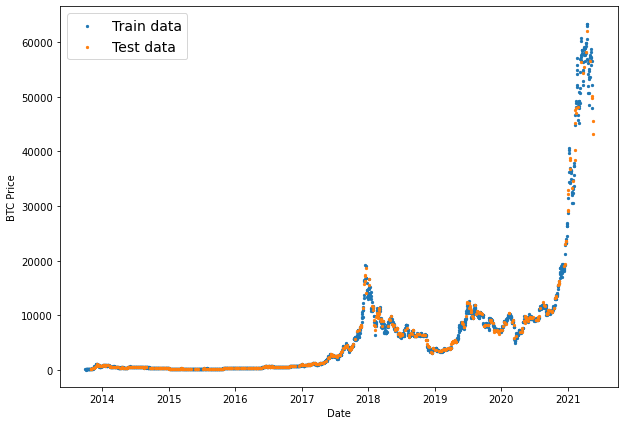

In [21]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label='Train data')
plt.scatter(X_test,y_test,s=5,label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Create train & test sets for time series (the right way)

Of course, there's no way we can actually access data from the future.

But we can engineer our test set to be in the future with respect to the training set.

To do this, we can create an abitrary point in time to split our data.

Everything before the point in time can be considered the training set and everything after the point in time can be considered the test set.

![time series train test split](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-train-test-split.png)
*Demonstration of time series split. Rather than a traditionaly random train/test split, it's best to split the time series data sequentially. Meaning, the test data should be data from the future when compared to the training data.*

In [22]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits
X_train,y_train = timesteps[:split_size],prices[:split_size]

# Create test splits
X_test,y_test = timesteps[split_size:],prices[split_size:]

len(X_train),len(X_test),len(y_train),len(y_test)

(2229, 558, 2229, 558)

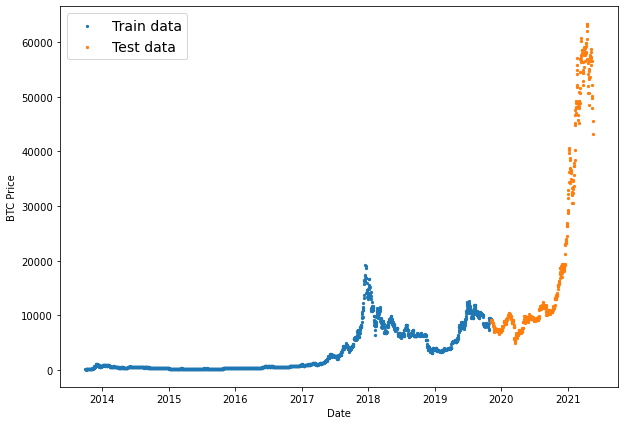

In [24]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label='Train data')
plt.scatter(X_test,y_test,s=5,label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

In [27]:
# Create a function to plot time series data
def plot_time_series(timesteps,values,format='.',start=0,end=None,label=None):
    '''
    Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
    Parameters
    ---------
    timesteps : array of timesteps
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (setting a value will index from end of timesteps & values)
    label : label to show on plot of values
    '''
    # Plot the series
    plt.plot(timesteps[start:end],values[start:end],format,label=label)
    plt.xlabel('Time')
    plt.ylabel('BTC price')
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)

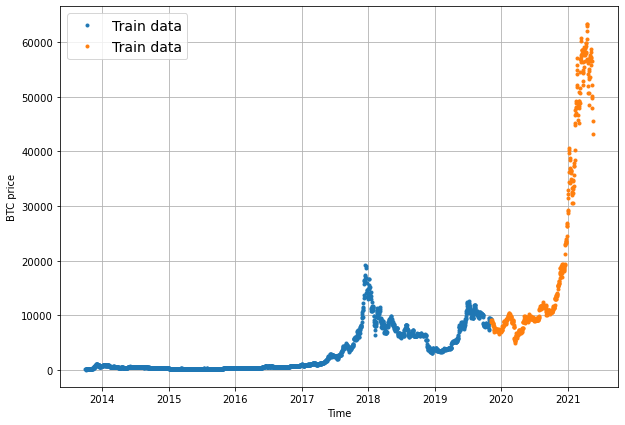

In [28]:
# Try out our plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,values=y_train,label='Train data')
plot_time_series(timesteps=X_test,values=y_test,label='Train data')

## Model 0: Naïve forecast (baseline)

As usual, let's start with a baseline.

One of the most common baseline models for time series forecasting, the naïve model (also called the [naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$ 

In English: 
> The prediction at timestep `t` (y-hat) is equal to the value at timestep `t-1` (the previous timestep).

Sound simple?

Maybe not.

In an open system (like a stock market or crypto market), you'll often find beating the naïve forecast with *any* kind of model is quite hard.

> 🔑 **Note:** For the sake of this notebook, an **open system** is a system where inputs and outputs can freely flow, such as a market (stock or crypto). Where as, a **closed system** the inputs and outputs are contained within the system (like a poker game with your buddies, you know the buy in and you know how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [30]:
# Create a naive forecast
naive_forecast = y_test[:-1] # Naive forecast equals every value excluding the last value
naive_forecast[:10],naive_forecast[-10:] # View first 10 and last 10

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

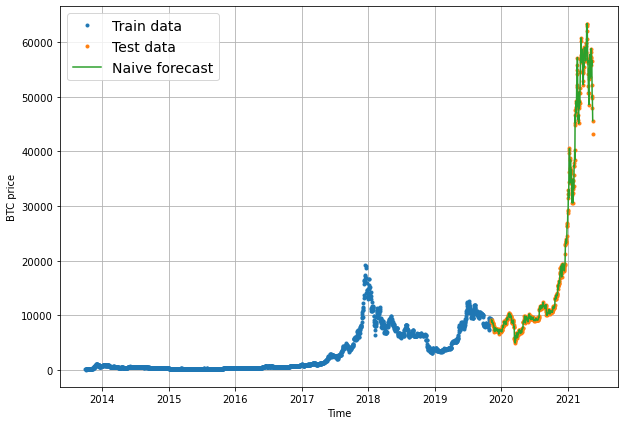

In [31]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

The naive forecast looks like it's following the data well. 

Let's zoom in to take a better look.

We can do so by creating an offset value and passing it to the `start` parameter of our `plot_time_series()` function.

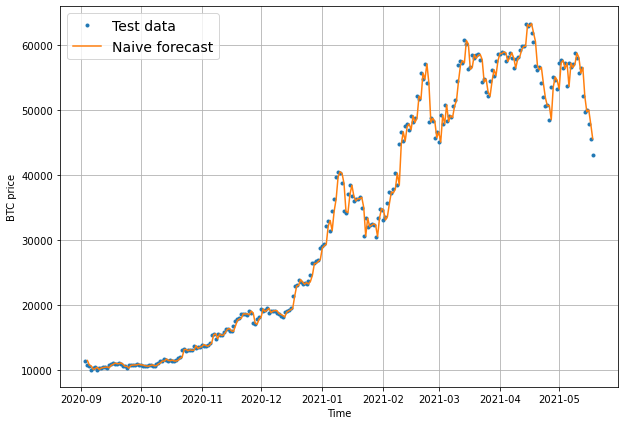

In [33]:
plt.figure(figsize=(10,7))
offsets = 300 # offset the values by 300 timesteps
plot_time_series(timesteps=X_test,values=y_test,start=offsets,label='Test data')
plot_time_series(timesteps=X_test[1:],values=naive_forecast,format='-',start=offsets,label='Naive forecast')